In [30]:
import geopandas as gpd
import shapely
from shapely.geometry import Point, LineString, MultiPoint, Polygon, box
from shapely import get_coordinates
from shapely import centroid
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from PIL import Image
import heapq

In [2]:
def house_centers(data):
    data['centers'] = [centroid(row) for row in data.geometry]#geometry
    return data
    
def house_inhabitants(data):
    
    data['Total_inhabit'] = [row*3 if row>0 else 0 for row in data.Apartments]
    data['Kids_kindergarden'] = [row*.05 if row>0 else 0 for row in data.Total_inhabit]
    data['Kids_school'] = [row*.05 if row>0 else 0 for row in data.Total_inhabit]
    data['Retired'] = [row*.05 if row>0 else 0 for row in data.Total_inhabit]
    data['Adults_cars'] = [row*.05 if row>0 else 0 for row in data.Total_inhabit]
    data['Adults_public'] = [row*.45 if row>0 else 0 for row in data.Total_inhabit]
    data['Adults_mobil'] = [row*.1 if row>0 else 0 for row in data.Total_inhabit]
    return data


def select_roads_foot(df, borders_df, polygon):
    df = pd.concat([df, borders_df], ignore_index=True)
    df['ok'] = [str(polygon.intersection(row)) for row in df.geometry] 
    df = df[df['ok']!='LINESTRING Z EMPTY']
    df = df[df['Foot']==1]
    return df
def select_roads_no_foot(df, borders_df, polygon):
    df = pd.concat([df, borders_df], ignore_index=True)
    df['ok'] = [str(polygon.intersection(row)) for row in df.geometry] 
    df = df[df['ok']!='LINESTRING Z EMPTY']
    df = df[df['Foot']==0]
    return df

def select_objects(df, borders_df, polygon):
    df = pd.concat([df, borders_df], ignore_index=True)
    df['ok'] = [str(polygon.intersection(row)) for row in df.geometry] 
    df['ok'] = [0 if row[-5:]=='EMPTY' else 1 for row in df['ok']]
    df = df[df['ok'] ==1]
    return df

def save_fig(df, figsize, fname):
    plot = df.plot(figsize = figsize)
    fig = plot.get_figure()
    #fig.savefig(f"{fname}.png") #save RGB pic
    canvas = FigureCanvas(fig)
    canvas.draw()

    # Convert the canvas to a numpy array (RGB)
    image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    # Close the figure to free up memory
    plt.close(fig)

    # Convert to grayscale using the standard formula
    gray_image = image[:,:,2]#
    gray_image = np.where(gray_image < 253, 0, gray_image)
       
    return gray_image#binary_image

def save_fig_1(df, figsize, fname):
    plot = df.plot(figsize = figsize)
    fig = plot.get_figure()
    #fig.savefig(f"{fname}.png") #save RGB pic
    canvas = FigureCanvas(fig)
    canvas.draw()

    # Convert the canvas to a numpy array (RGB)
    image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    # Close the figure to free up memory
    plt.close(fig)

    # Convert to grayscale using the standard formula
    
       
    return image#binary_image
    

In [3]:
def select_region(xy_min, xy_max, z):
    coords = ((xy_min[0]-z, xy_min[1]-z), (xy_min[0]-z, xy_max[1]+z),  (xy_max[0]+z, xy_max[1]+z), (xy_max[0]+z, xy_min[1]-z),(xy_min[0]-z, xy_min[1]-z))
    polygon = Polygon(coords)
    points = []
    for point in coords:
        points.append(Point(point))
    #создаем временный датафрейм для добавления к фреймам объектов
    border_points = {'geometry': points}
    borders_df = pd.DataFrame.from_dict(border_points)
    return borders_df, polygon
    

In [4]:
def convert_pic_to_speed_matrix(arr, speed_0, speed_1):
    arr = np.where(arr!=0, speed_0, speed_1)
    return arr

In [5]:
#dijkstra - big map with diagonals adjusted for diaonals length

def dijkstra_map (matrix, start, end, verbose=1):
    if verbose>0: 
        print(f'Leg start - {start}, route end: {end}')
    m, n = matrix.shape
    # Create a priority queue to store (cost, position) tuples
    pq = [(matrix[start], start)]
    # Create a distance matrix to store the minimum time to reach each cell
    dist = np.full((m, n), np.inf)
    dist[start] = matrix[start]
    # Create a predecessor matrix to store the path
    predecessor = np.full((m, n), None, dtype=object)
    # Directions for moving to adjacent cells (right, down, left, up, and diagonals)
    directions = [(0, 1), (1, 0), (0, -1), (-1, 0), (1, 1), (-1, -1), (1, -1), (-1, 1)]
    
    while pq:
        current_cost, (x, y) = heapq.heappop(pq)
        # If we have reached the destination, construct the path
        if (x, y) == end:
            path = []
            while (x is not None)&(y is not None):
                path.append((x, y))
                
                if predecessor[x, y] is not None:
                    x, y = predecessor[x, y]
                else:
                    x, y = None,None
                
            path.reverse()
            return current_cost, path
        
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < m and 0 <= ny < n:
                new_cost = current_cost + (matrix[nx, ny] + matrix[x, y])*(np.sqrt(dx**2+dy**2))/2
                if new_cost < dist[nx, ny]:
                    dist[nx, ny] = new_cost
                    predecessor[nx, ny] = (x, y)
                    heapq.heappush(pq, (new_cost, (nx, ny)))
    
    # If there's no valid path (which shouldn't happen in a grid), return inf
    return np.inf, []

#create timings for each square at the map - map with speed is the source
def update_map_time(df, grid_size=1):
    return np.divide(grid_size,df)

def create_greyscale_matrix(matrix):
    fig, ax = plt.subplots()
    ax.imshow(matrix, cmap='gray', vmin=0, vmax=25)

    return fig, ax

def color_route_on_matrix(ax, cell_width, cell_height, start_point, daily_moves, planned_route):
    # Define colors for the route
    start_color = 'green'
    daily_move_color = 'blue'
    planned_route_color = 'red'

    # Helper function to fill a cell with a color
    def fill_cell(point, color):
        y,x = point
        rect = plt.Rectangle((x * cell_width, y * cell_height), cell_width, cell_height, linewidth=1, edgecolor=color, facecolor=color)
        ax.add_patch(rect)

    # Fill the start point
    fill_cell(start_point, start_color)
    
    # Fill the daily moves
    for move in daily_moves:
        fill_cell(move, daily_move_color)
    
    # Fill the planned route
    for move in planned_route:
        fill_cell(move, planned_route_color)
    
    return ax

# Example usage
#m, n = 100, 100  # Example matrix size

In [6]:
# реперные точки для рисунков
def create_rectangle(point, half_width, half_height):
    x, y = point.x, point.y
    return box(x - half_width, y - half_height, x + half_width, y + half_height)


def create_polygons(xy_min, xy_max, z1):
    coords1 =  ((xy_min[0]-z1, xy_min[1]-z1), (xy_min[0]-z1, xy_max[1]+z1),  (xy_max[0]+z1, xy_max[1]+z1), (xy_max[0]+z1, xy_min[1]-z1),(xy_min[0]-z1, xy_min[1]-z1))
    points = []
    gdf = gpd.GeoDataFrame()
    for point in coords1:
        print(point)
        #points.append(Point(point))
        tmp = gpd.GeoDataFrame(geometry=[Point(point)])#, crs="EPSG:4326"
        gdf = pd.concat([gdf, tmp], ignore_index=True) 

        # Apply the function to create a rectangle around each point
    gdf['rectangle'] = gdf.geometry.apply(create_rectangle, half_width=half_width, half_height=half_height)




    #check_points = {'geometry': points}
    #check_points_df = pd.DataFrame.from_dict(check_points)
    #check_points_df#['Foot'] = 1

    check_points_df = gdf
    check_points_df['geometry'] = check_points_df['rectangle']
    check_points_df['rectangle'] = 1
    return check_points_df
#check_points_df = create_polygons(xy_min, xy_max, z1)
#check_points_df

In [7]:
def drop_empty_from_array(arr):
    filtered_arr = arr[~(pd.isnull(arr) | (arr == None))]
    return filtered_arr


In [8]:
#Выбрать из базы метро
def select_metro(df):
    metro_list = drop_empty_from_array(df.Text.unique())
    metro = df[df.Text.isin(metro_list)]
    return metro

In [9]:
#Выбрать из базы остановки
def select_stops(df):
    substrings = ['остановка']
    # Combine substrings into a single regular expression pattern
    pattern = '|'.join(substrings)
    # Select rows where 'City' column contains any of the substrings
    filtered_df = df[df.TrType.str.contains(pattern, case=False, na=False)]

    return filtered_df

In [10]:
figsize = (20,20) #select size of picture and thus matrix
#выбираем максимальную площадь карты для рассчетов (на перспективу) с запасом +-z
z = 800
z1 = 800
half_width = 0.01
half_height = 0.01

In [11]:
fnames = ['Streets_исходные.shp', "Дома_исходные.shp", 'Выходы_метро.shp', 'Остановки_ОТ.shp', "House_1очередь_ЖК.shp",'Streets_1очередь.shp','Streets_2очередь.shp',"House_2очередь_ЖК.shp",'Streets_3очередь.shp',"House_3очередь_ЖК.shp"]

In [12]:
#Находим интересующие нас размеры
path = os.getcwd()+"/vector/"
combined = pd.DataFrame()
extension = ["House_1очередь_ЖК.shp","House_2очередь_ЖК.shp","House_3очередь_ЖК.shp"]
for item in extension :
    file_path = path+item  # Укажи путь к твоему файлу
    tmp = gpd.read_file(path+item)
    combined = pd.concat([combined, tmp], ignore_index=True)

#смотрим координаты крайних точек строящихся объектов (домов) на карте
xy_min = np.min(get_coordinates(combined.geometry), axis=0)
xy_max = np.max(get_coordinates(combined.geometry), axis=0)

print(xy_min[0], xy_min[1])
print(xy_min[0], xy_max[1])
print(xy_max[0], xy_min[1])
print(xy_max[0], xy_max[1])

4171713.34 7467405.39
4171713.34 7469492.95
4174304.47 7467405.39
4174304.47 7469492.95


In [13]:
#создаем полигон с расширенными координатами для выборки из слоев добавляя полосы шириной z 
#по краям и датафрейм для добавления (нормирования)
borders_df, polygon = select_region(xy_min, xy_max, z)
borders_df

,geometry
0,POINT (4170913.34 7466605.39)
1,POINT (4170913.34 7470292.95)
2,POINT (4175104.47 7470292.95)
3,POINT (4175104.47 7466605.39)
4,POINT (4170913.34 7466605.39)


C:\Users\andre\miniconda3\envs\python\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: C:\Users\andre\OneDrive\Desktop\0-Rojects\2024-International/vector/Дома_исходные.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


<AxesSubplot: >

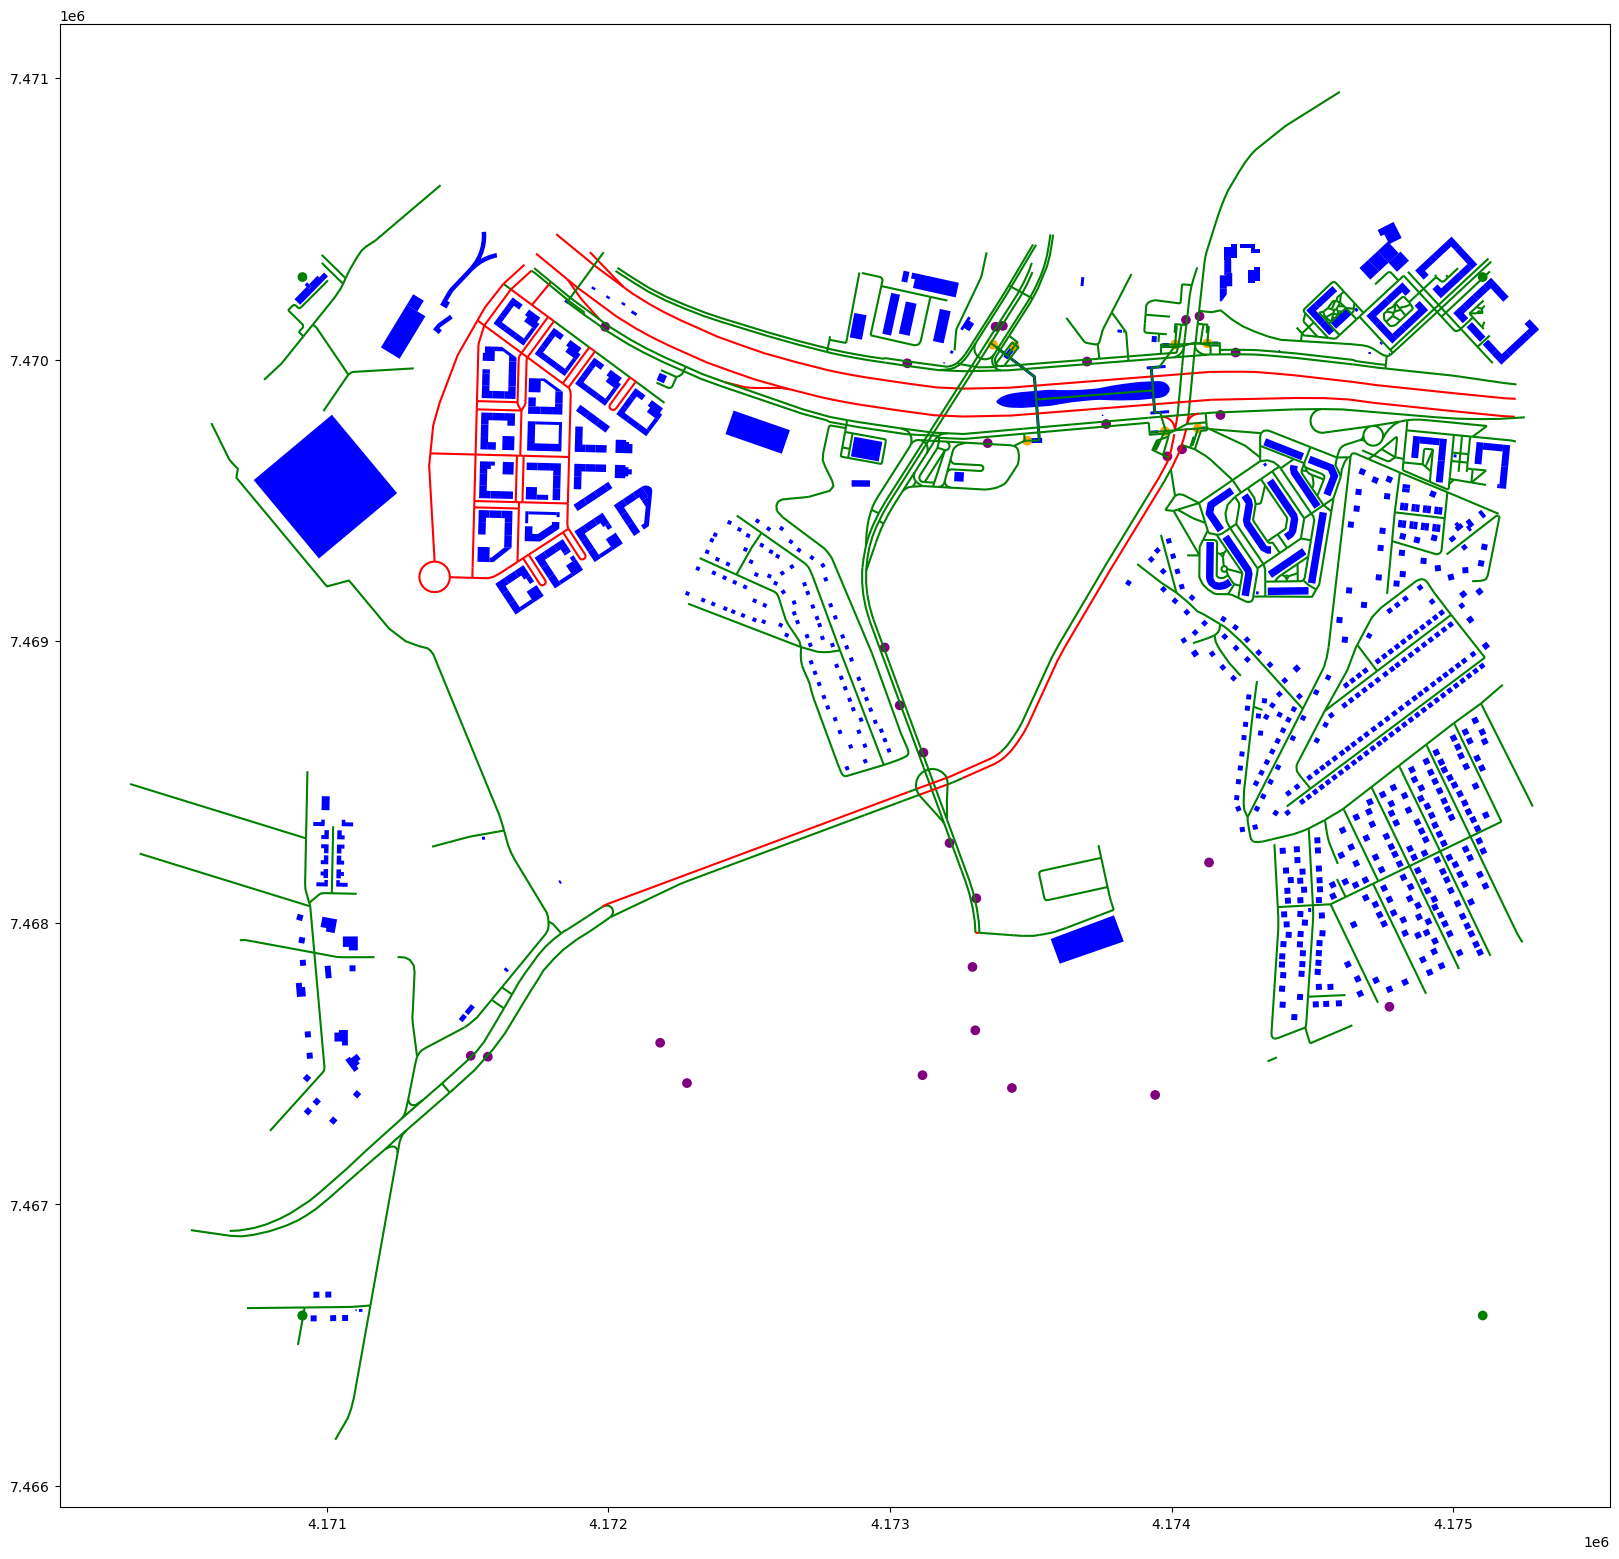

In [14]:

# Загрузка данных из файла .shp - исходная ситуация
path = os.getcwd()+"/vector/"
colors = ['red', 'green', 'purple', 'orange']
file_path = path+'Дома_исходные.shp'  # Укажи путь к твоему файлу
data1 = gpd.read_file(file_path)
data1['color'] = 'blue'
file_path = path+'Streets_исходные.shp'  # Укажи путь к твоему файлу
data2 = gpd.read_file(file_path)
data2['color'] = [colors[row] for row in data2.Foot]
file_path = path+'Выходы_метро.shp'  # Укажи путь к твоему файлу
data3 = gpd.read_file(file_path)
data3['color'] = colors[3]
file_path = path+'Остановки_ОТ.shp'  # Укажи путь к твоему файлу
data4 = gpd.read_file(file_path)
data4['color'] = colors[2]

combined = pd.concat([data1, data2, data3, data4], ignore_index = True)

# Отображение данных на карте
#colors = ['blue', 'green', 'purple', 'orange']

#data.plot(column='color', cmap='Set1', legend=True, figsize = (20,50))
#combined.plot(color = combined['color'], figsize = figsize)

#Добавляем реперные точки для лучшего видения и выделяем только объекты в нужном регионе

df = select_objects(combined, borders_df, polygon)
df = df.reset_index()
df['color'] = df['color'].fillna('green')
df.plot(color = df['color'], figsize = figsize)
#fig, ax = plt.subplots(figsize=figsize)  # Set figure size
#df1.plot(ax=ax, color=df1.color, markersize=1)  # Adjust marker color and size
#plt.axis('off')

(4170051.02, 4175554.98, 7465925.0065, 7471189.9035)

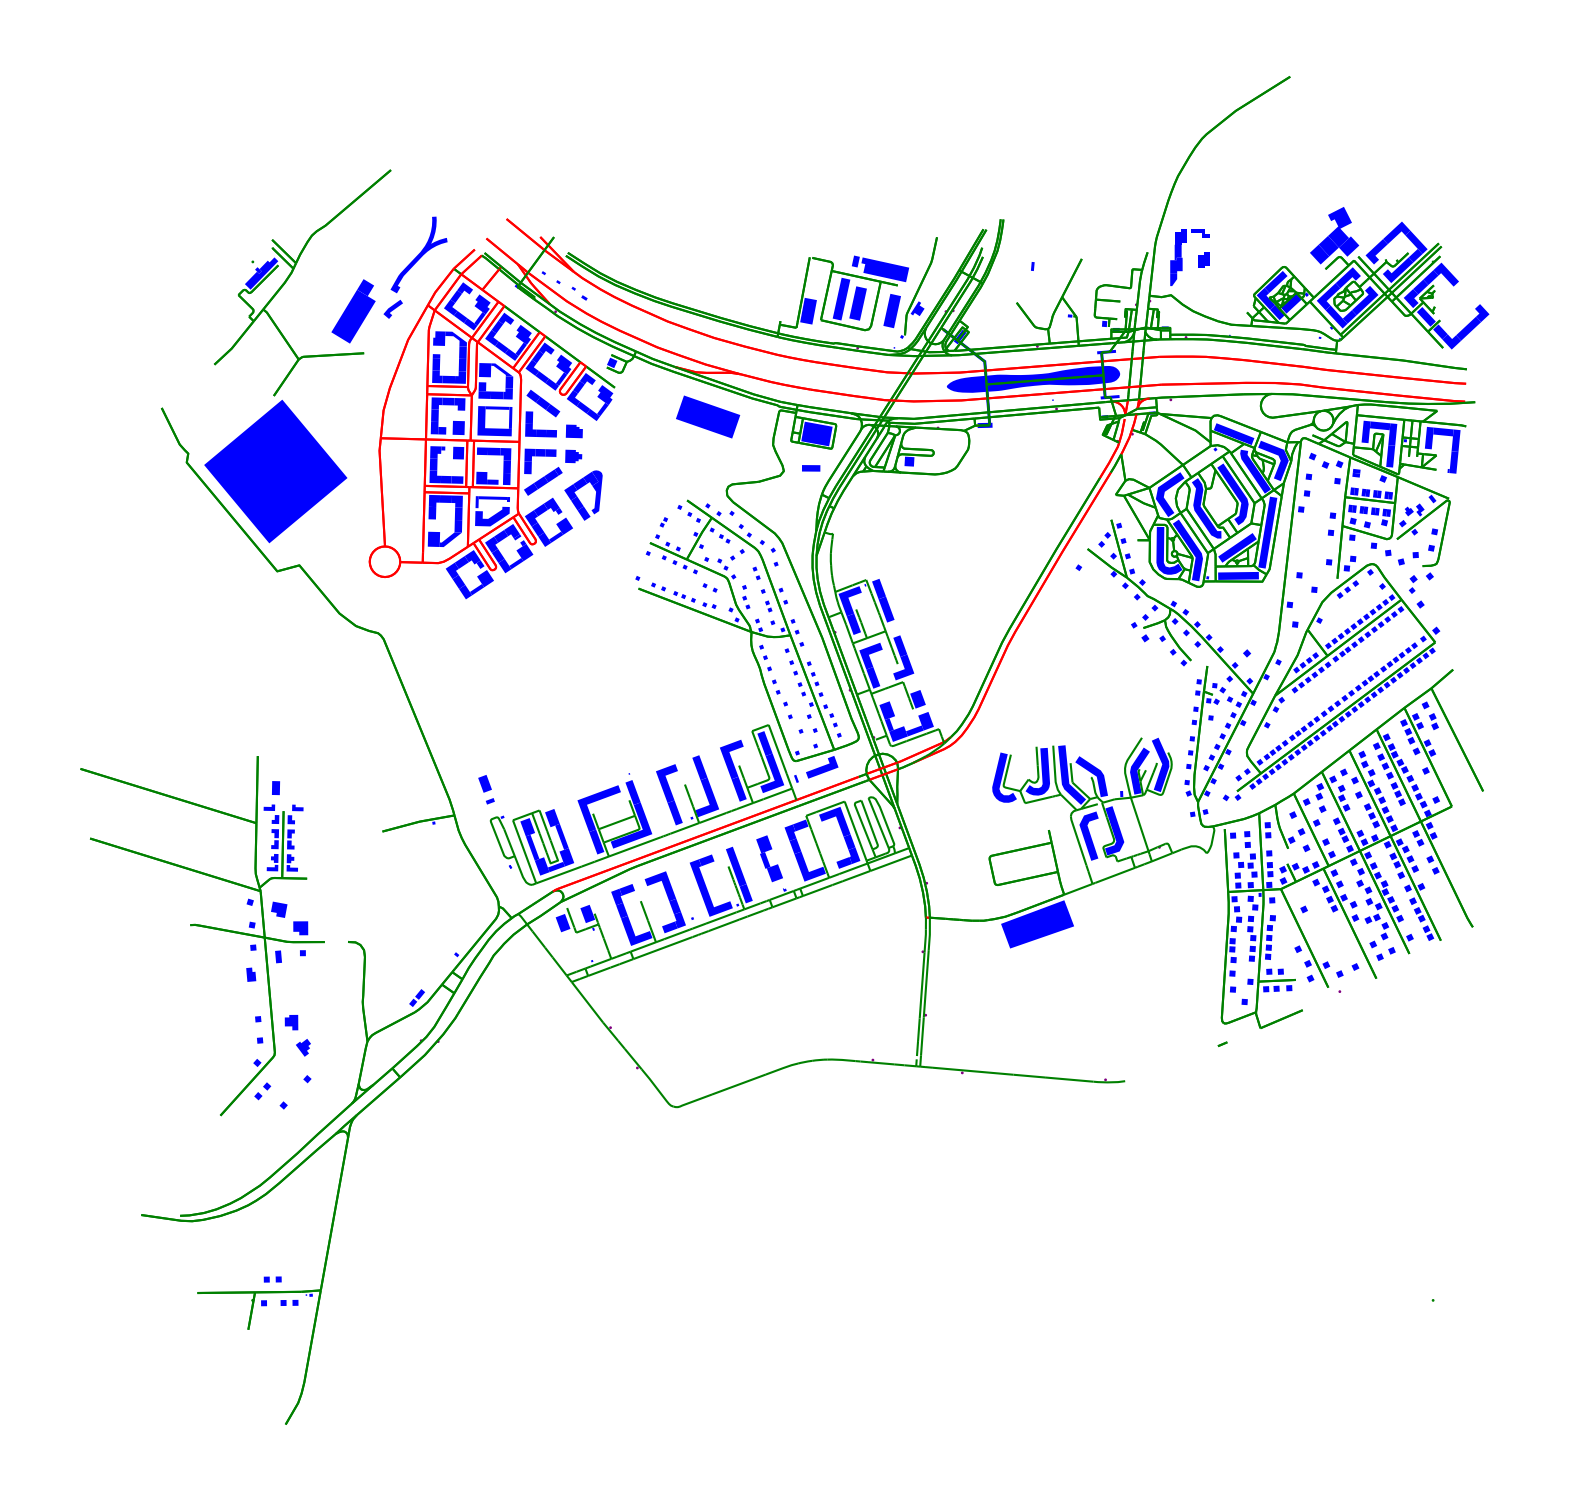

In [15]:


file_path = path+"House_1очередь_ЖК.shp"  # Укажи путь к твоему файлу
data_1 = gpd.read_file(file_path)
data_1['color'] = 'blue'
file_path = path+'Streets_1очередь.shp'  # Укажи путь к твоему файлу
data_2 = gpd.read_file(file_path)
data_2['color'] = [colors[row] for row in data_2.Foot]
combined = pd.concat([combined, data_1, data_2], ignore_index = True)

df1 = select_objects(combined, borders_df, polygon)
df1 = df1.reset_index()
df1['color'] = df1['color'].fillna('green')
#df1.plot(color = df1['color'], figsize = figsize)
fig, ax = plt.subplots(figsize=figsize)  # Set figure size
df1.plot(ax=ax, color=df1.color, markersize=1)  # Adjust marker color and size
plt.axis('off')

In [16]:
df1 = house_centers(df1)
df1.centers
houses = df1[(df1.Type == 'Жилые дома')&(df1.index>1000)]
houses.geometry = houses.centers
schools = df1[df1.Type == 'Школы']
schools.geometry = schools.centers
kinder_g = df1[df1.Type == 'Дошкольные']
kinder_g.geometry =kinder_g.centers
stops = select_stops(df1)
metro = select_metro(df1)
print(f'Number of houses in vicinity - {len(houses)}')
print(f'Number of schools in vicinity - {len(schools)}')
print(f'Number of kindergardens in vicinity - {len(kinder_g)}')
print(f'Number of metro entrances in vicinity - {len(metro)}')
print(f'Number of bus stops in vicinity - {len(stops)}')

Number of houses in vicinity - 30
Number of schools in vicinity - 1
Number of kindergardens in vicinity - 1
Number of metro entrances in vicinity - 7
Number of bus stops in vicinity - 29


C:\Users\andre\miniconda3\envs\python\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [17]:
schools.geometry 
kinder_g.geometry

46    POINT (4170942.166 7470252.383)
Name: centers, dtype: geometry

In [21]:
# Function to map a point's coordinates to pixel coordinates
def to_pixel_coords(x, y, x_min, x_max, y_min, y_max, width, height):
    px = int((x - x_min) / (x_max - x_min) * width)
    py = int((y_max - y) / (y_max - y_min) * height)  # Reverse y-axis for image coordinates
    return px, py

def draw_map (df):
    fig, ax = plt.subplots(figsize=figsize)  # Set figure size
    
    df1.plot(ax=ax, color=df1.color, markersize=1)  # Adjust marker color and size
    #plt.axis('off')
    fig.savefig(f"Map_local.png") #save RGB pic
    canvas = FigureCanvas(fig)
    canvas.draw()
    

    # Convert to a numpy array
    image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    # Close the figure to free up memory
    plt.close(fig)
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()

    # Get image dimensions
    height, width, _ = (1481, 1550, 1)#image.shape поправка на ширину полей
    height = height*figsize[0]/20
    width = width*figsize[0]/20
    
    return  x_min, x_max, y_min, y_max, width, height

# Calculate pixel coordinates for each point in the GeoDataFrame - for houses and stops and 
def find_point_coordinates(df, x_min, x_max, y_min, y_max, width, height):
    band_x = 250 *figsize[0]/20#поправка на оси
    band_y = 265 *figsize[0]/20
    pixel_coords = [to_pixel_coords(point.x, point.y, x_min, x_max, y_min, y_max, width, height)
                    for point in df.geometry]
    coord = {}
    # Output the pixel coordinates
    for idx, (x, y) in enumerate(pixel_coords):
        print(f"Point {idx}: Pixel coordinates -> ({int(y+band_y)}, {int(x+band_x)})")
        coord[idx] = (int(y+band_y), int(x+band_x))
    return coord

In [22]:
x_min, x_max, y_min, y_max, width, height = draw_map (df1)
metro_coord = find_point_coordinates(metro, x_min, x_max, y_min, y_max, width, height)

Point 0: Pixel coordinates -> (584, 1183)
Point 1: Pixel coordinates -> (586, 1204)
Point 2: Pixel coordinates -> (680, 1217)
Point 3: Pixel coordinates -> (671, 1355)
Point 4: Pixel coordinates -> (668, 1388)
Point 5: Pixel coordinates -> (583, 1397)
Point 6: Pixel coordinates -> (584, 1365)


In [23]:
house_coord = find_point_coordinates(houses, x_min, x_max, y_min, y_max, width, height)
house_coord

Point 0: Pixel coordinates -> (1025, 1377)
Point 1: Pixel coordinates -> (1089, 1329)
Point 2: Pixel coordinates -> (1087, 1354)
Point 3: Pixel coordinates -> (1030, 1282)
Point 4: Pixel coordinates -> (1019, 1401)
Point 5: Pixel coordinates -> (1030, 1334)
Point 6: Pixel coordinates -> (1031, 1307)
Point 7: Pixel coordinates -> (1036, 1241)
Point 8: Pixel coordinates -> (1091, 1083)
Point 9: Pixel coordinates -> (1106, 1041)
Point 10: Pixel coordinates -> (1113, 1008)
Point 11: Pixel coordinates -> (1129, 979)
Point 12: Pixel coordinates -> (1141, 947)
Point 13: Pixel coordinates -> (1168, 827)
Point 14: Pixel coordinates -> (1177, 803)
Point 15: Pixel coordinates -> (1155, 908)
Point 16: Pixel coordinates -> (1170, 868)
Point 17: Pixel coordinates -> (1022, 973)
Point 18: Pixel coordinates -> (1020, 1010)
Point 19: Pixel coordinates -> (1046, 909)
Point 20: Pixel coordinates -> (1044, 945)
Point 21: Pixel coordinates -> (1074, 874)
Point 22: Pixel coordinates -> (1068, 835)
Point 23:

{0: (1025, 1377),
 1: (1089, 1329),
 2: (1087, 1354),
 3: (1030, 1282),
 4: (1019, 1401),
 5: (1030, 1334),
 6: (1031, 1307),
 7: (1036, 1241),
 8: (1091, 1083),
 9: (1106, 1041),
 10: (1113, 1008),
 11: (1129, 979),
 12: (1141, 947),
 13: (1168, 827),
 14: (1177, 803),
 15: (1155, 908),
 16: (1170, 868),
 17: (1022, 973),
 18: (1020, 1010),
 19: (1046, 909),
 20: (1044, 945),
 21: (1074, 874),
 22: (1068, 835),
 23: (1099, 788),
 24: (965, 1162),
 25: (915, 1143),
 26: (917, 1111),
 27: (863, 1090),
 28: (855, 1123),
 29: (979, 1136)}

In [24]:
# Define RGB values for each color - матрица соответствия скоростей цвету
color_map = {
    (0, 128, 0): 1,      # Green -> 1
    (255, 0, 0): 0.2,      # Red -> 2
    (255, 255, 0): 3,    # Yellow -> 3
    (0, 0, 255): 0.1,      # Blue -> 4
    (128, 0, 128): 1,     # Purple -> 5
    (255, 255, 255): 0.5
}
image = Image.open("Map_local.png")

# Convert the image to RGB mode if not already in that mode
image = image.convert("RGB")
# Convert the image to a numpy array
image_array = np.array(image)


result_matrix = np.zeros((image_array.shape[0], image_array.shape[1]), dtype=np.float32)

# Replace each color with its corresponding value - заменяем цвета
for rgb, value in color_map.items():
    print(rgb)
    mask = np.all(image_array == rgb, axis=-1)
    result_matrix[mask] = value

(0, 128, 0)
(255, 0, 0)
(255, 255, 0)
(0, 0, 255)
(128, 0, 128)
(255, 255, 255)


In [25]:
# Матрица скоростей
result_matrix
result_matrix = np.where(result_matrix==0, 0.3, result_matrix)
timings = 1./result_matrix

In [28]:
house_coord[0]
metro_coord[0]

(584, 1183)

In [ ]:
#Расчет времени для всех дорожек и прорисовка дорожек

In [31]:
%%time
#Пример расчета одной дорожки

start = house_coord[0]
end = metro_coord[0]

current_cost, path = dijkstra_map (timings, start, end, verbose=1)

Leg start - (1025, 1377), route end: (584, 1183)
CPU times: total: 31 s
Wall time: 31.6 s


In [33]:
print(f'time for route (relative) - {current_cost}')
path

time for route (relative) - 886.5415439871181


[(1025, 1377),
 (1025, 1378),
 (1026, 1379),
 (1026, 1380),
 (1025, 1381),
 (1024, 1382),
 (1023, 1383),
 (1022, 1383),
 (1021, 1384),
 (1020, 1385),
 (1019, 1385),
 (1018, 1386),
 (1017, 1387),
 (1016, 1387),
 (1015, 1388),
 (1014, 1388),
 (1013, 1389),
 (1012, 1390),
 (1011, 1390),
 (1010, 1390),
 (1009, 1390),
 (1008, 1390),
 (1007, 1390),
 (1006, 1390),
 (1005, 1390),
 (1004, 1390),
 (1003, 1390),
 (1002, 1390),
 (1001, 1390),
 (1000, 1390),
 (999, 1390),
 (998, 1390),
 (997, 1390),
 (996, 1390),
 (995, 1390),
 (994, 1390),
 (993, 1390),
 (992, 1390),
 (991, 1390),
 (990, 1390),
 (989, 1390),
 (988, 1390),
 (987, 1390),
 (986, 1390),
 (985, 1390),
 (984, 1391),
 (983, 1391),
 (982, 1391),
 (981, 1391),
 (980, 1391),
 (979, 1391),
 (978, 1391),
 (977, 1391),
 (976, 1391),
 (975, 1391),
 (974, 1391),
 (973, 1391),
 (972, 1391),
 (971, 1391),
 (970, 1391),
 (969, 1391),
 (968, 1391),
 (967, 1391),
 (966, 1391),
 (965, 1391),
 (964, 1391),
 (963, 1391),
 (962, 1391),
 (961, 1391),
 (96